In [1]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Activation, Conv2D, Input, Lambda, Flatten, Permute
from keras.optimizers import Adam, SGD, RMSprop
import keras.backend as K
from tqdm import tqdm

Using TensorFlow backend.


# Agent

In [2]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class Agent():
    
    def __init__(self, state_size, action_size, weights=None):
        
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model()
                   
    
        self.current_state = []
            
        
    def build_model(self):
        
        input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
        model = Sequential()

        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
        model.add(Conv2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(4))
        model.add(Activation('linear'))
        print(model.summary())
        #model.summary()
        
        model.compile(Adam(lr=.00025), loss='mae')
        return model
    
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch
        
    
    def next_action(self, state):
        actions = self.model.predict(state)[0]
        return np.argmax(actions), np.max(actions)
     

# Env

In [3]:
env = gym.make('Breakout-v4')
np.random.seed(123)
env.seed(123)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [4]:
agent = Agent(state_size, action_size)
agent.model.load_weights("weights/dqn_Breakout-v4_weights_10000000.h5f")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

In [5]:
actions = env.unwrapped.get_action_meanings()

In [6]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

def get_frames_and_features(env, agent, state_size, nb_steps=1000):
    
    model = agent.model
    
    flatten_layer = model.get_layer('activation_4')
    iterate = K.function([model.input], [flatten_layer.output[0]])
    features_list = []
    action_list = []
    value_list = []
    frames = []
    while nb_steps > 0:
        state = env.reset()
        frames.append(state)
        state = agent.process_observation(state)
        current_state = np.array([state, state, state, state])
        done = False
        
        print (nb_steps)
        while True:

            x = agent.process_state_batch(current_state)
            x = np.expand_dims(x, axis=0)
            action, value = agent.next_action(x) 
            action_list.append(action)
            value_list.append(value)
            next_state, reward, done, _ = env.step(action)
            frames.append(next_state)
            features = iterate([x])[0]
            features_list.append(features)
            next_state = agent.process_observation(next_state)
            current_state = np.insert(current_state[1:,:,:], 3, next_state, axis=0)
            nb_steps -= 1
            if nb_steps < 0 or done:
                break
    
    return features_list, action_list, value_list, frames

In [7]:
features_list, actions_list, value_list, frames = get_frames_and_features(env, agent, state_size, 5000)
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca_features = pca.fit_transform(features_list)

5000
3168
1490


In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(pca_features)
tsne_results.shape

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5001 samples in 0.010s...
[t-SNE] Computed neighbors for 5001 samples in 0.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5001
[t-SNE] Computed conditional probabilities for sample 2000 / 5001
[t-SNE] Computed conditional probabilities for sample 3000 / 5001
[t-SNE] Computed conditional probabilities for sample 4000 / 5001
[t-SNE] Computed conditional probabilities for sample 5000 / 5001
[t-SNE] Computed conditional probabilities for sample 5001 / 5001
[t-SNE] Mean sigma: 0.397509
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.654518
[t-SNE] KL divergence after 300 iterations: 2.598081


(5001, 2)

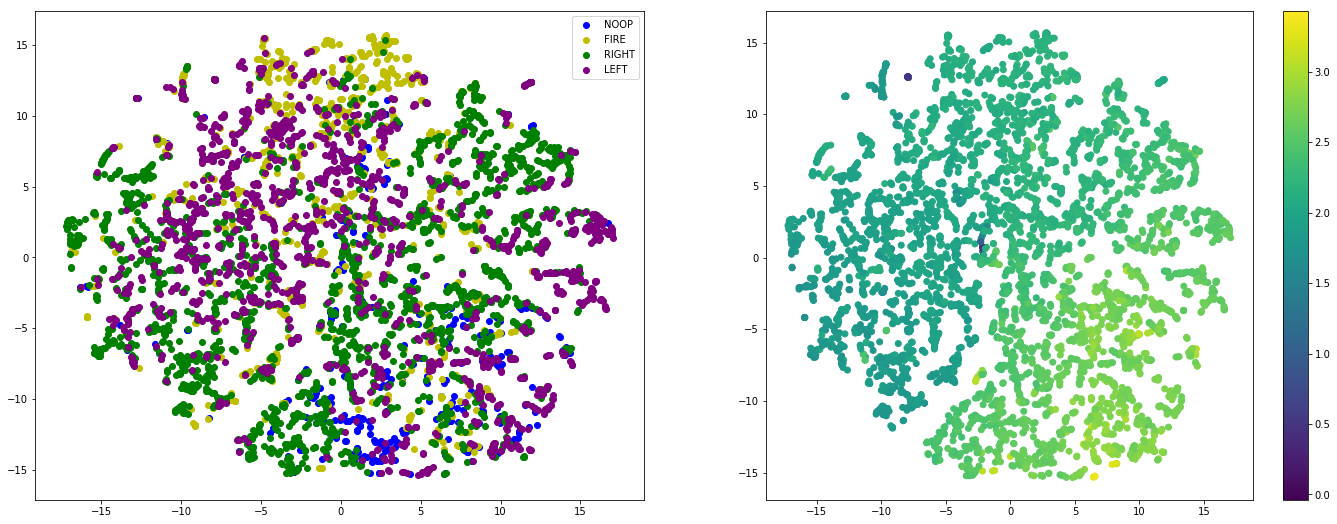

In [9]:
import matplotlib.pyplot as plt
actions = env.unwrapped.get_action_meanings()
colors = ['b','y','green', 'purple']
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
for i in [0,1,2,3]:
    x = [tsne_results[:,0][index]  for index in range(len(actions_list)) if actions_list[index] == i]
    y = [tsne_results[:,1][index]  for index in range(len(actions_list)) if actions_list[index] == i]
    plt.scatter(x, y, c=colors[i], label=actions[i])
plt.legend()
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.misc import imread, imresize

def imscatter(x, y, frames, ax=None, zoom=1, linewidth=0):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, frame in zip(x, y, frames):
        try:
            im = frame
        except:
            print(p)
            continue
        im = imresize(im,(420,340))
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data',
                            frameon=True, pad=0.1, 
                            bboxprops=dict(edgecolor='red',
                                           linewidth=linewidth))
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


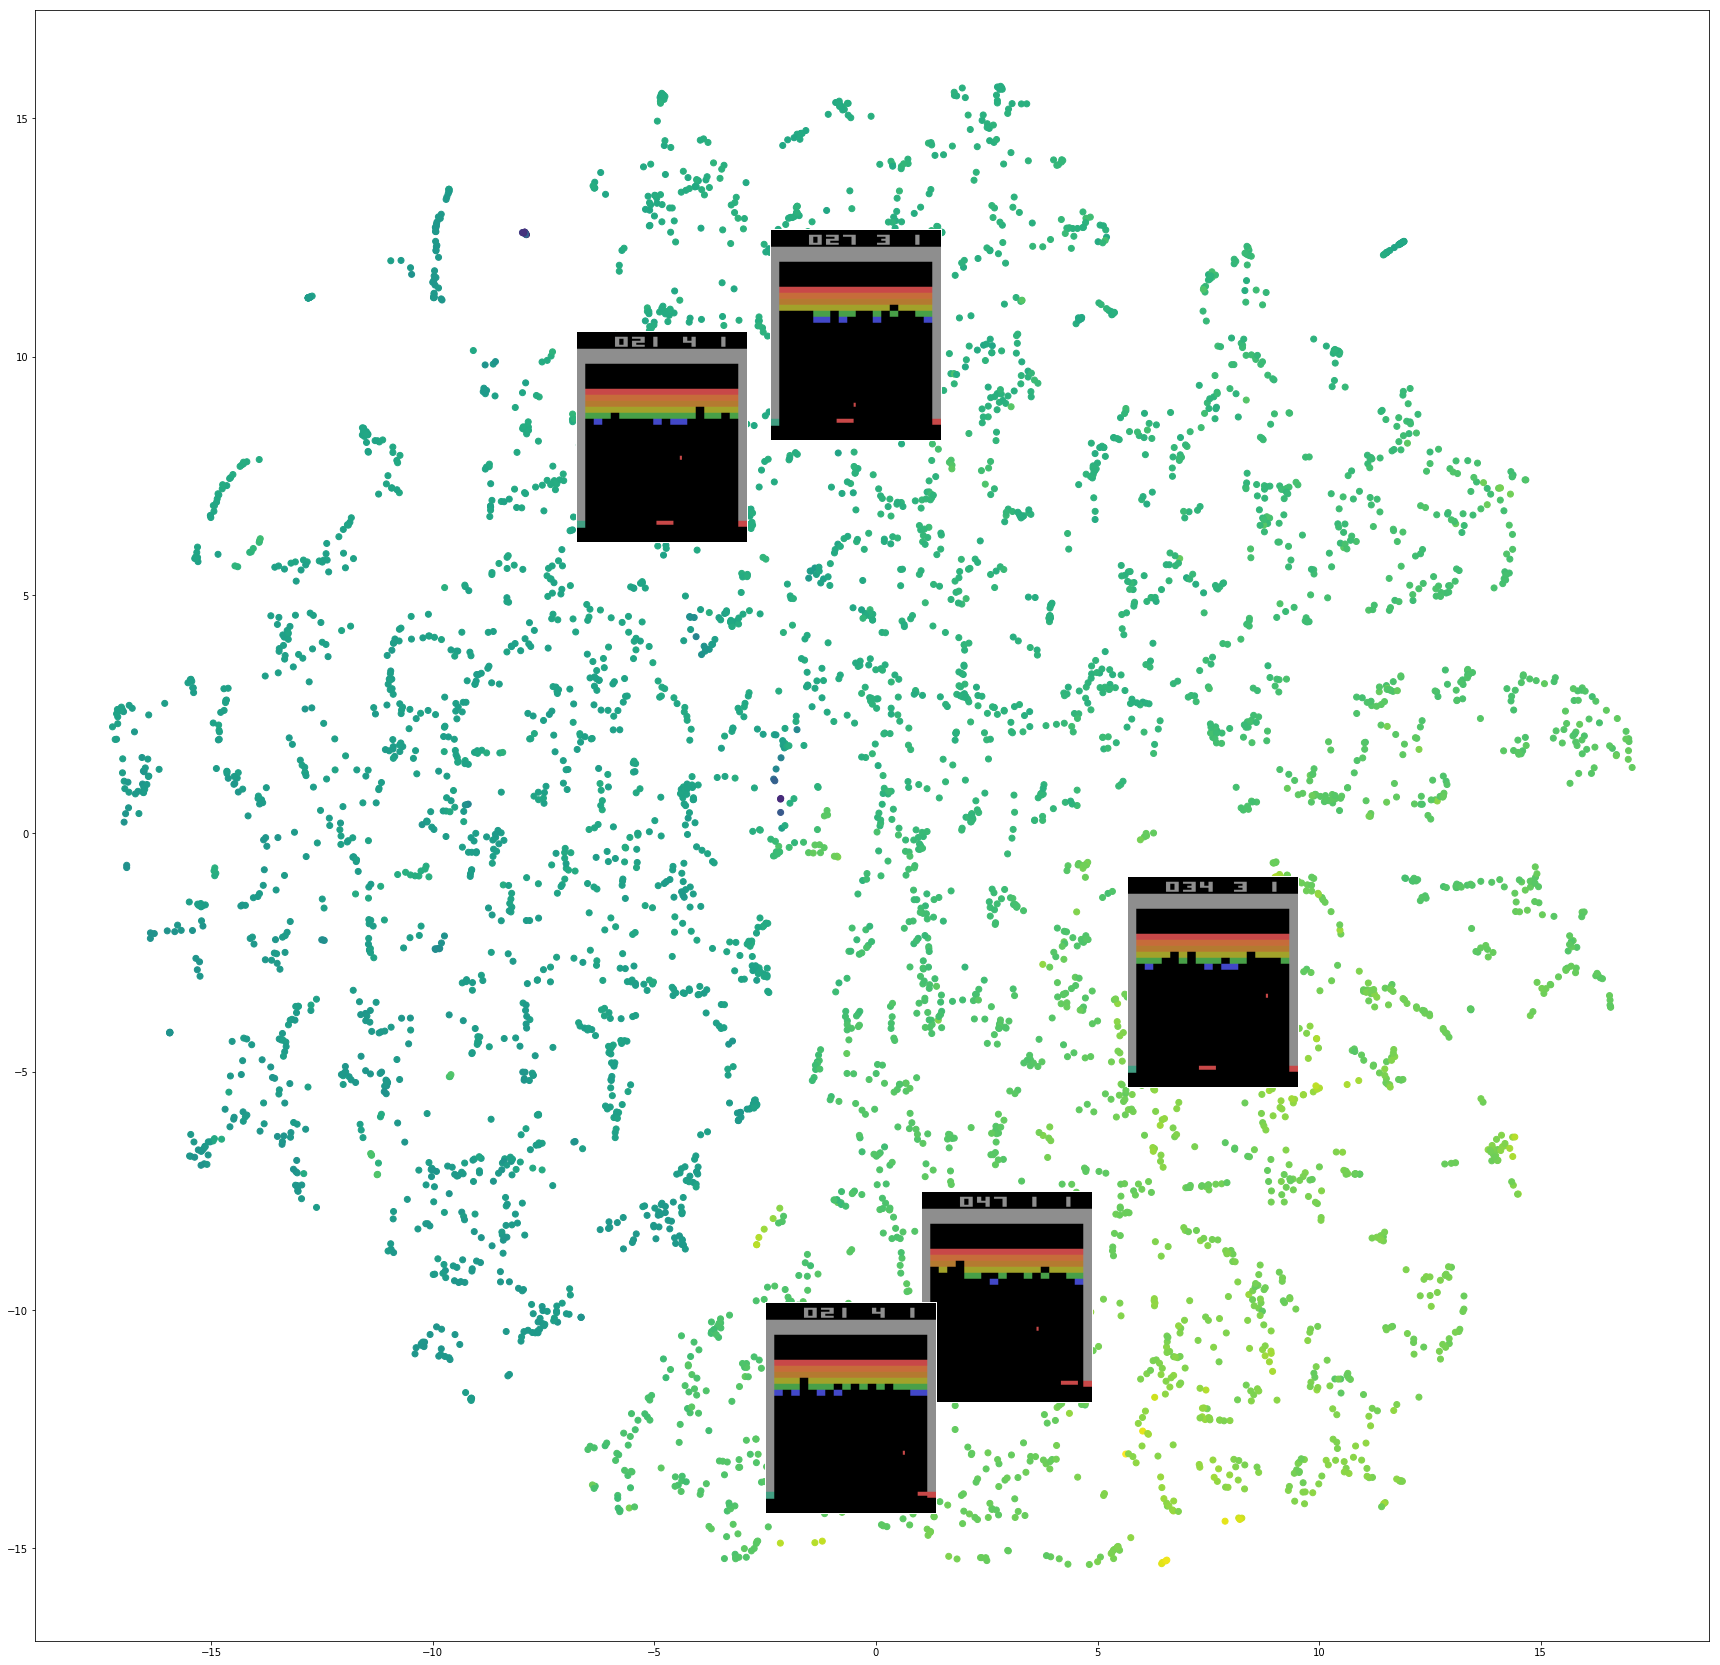

In [11]:
import random
l =range(len(tsne_results[:,0]))
ind = random.sample(l, 5)

imx = [tsne_results[:,0][index] for index in ind]
imy = [tsne_results[:,1][index] for index in ind]
im_fig = [frames[index] for index in ind]

fig, ax = plt.subplots(figsize=(30, 30))
imscatter(imx, imy, im_fig, zoom=0.5, ax=ax);
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)

In [12]:
frames2 = frames.copy()
for i in range(3, len(frames)):
    frames2[i] = frames[i] + 0.4* frames[i-1] + 0.4* frames[i-2] + 0.4* frames[i-3]

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


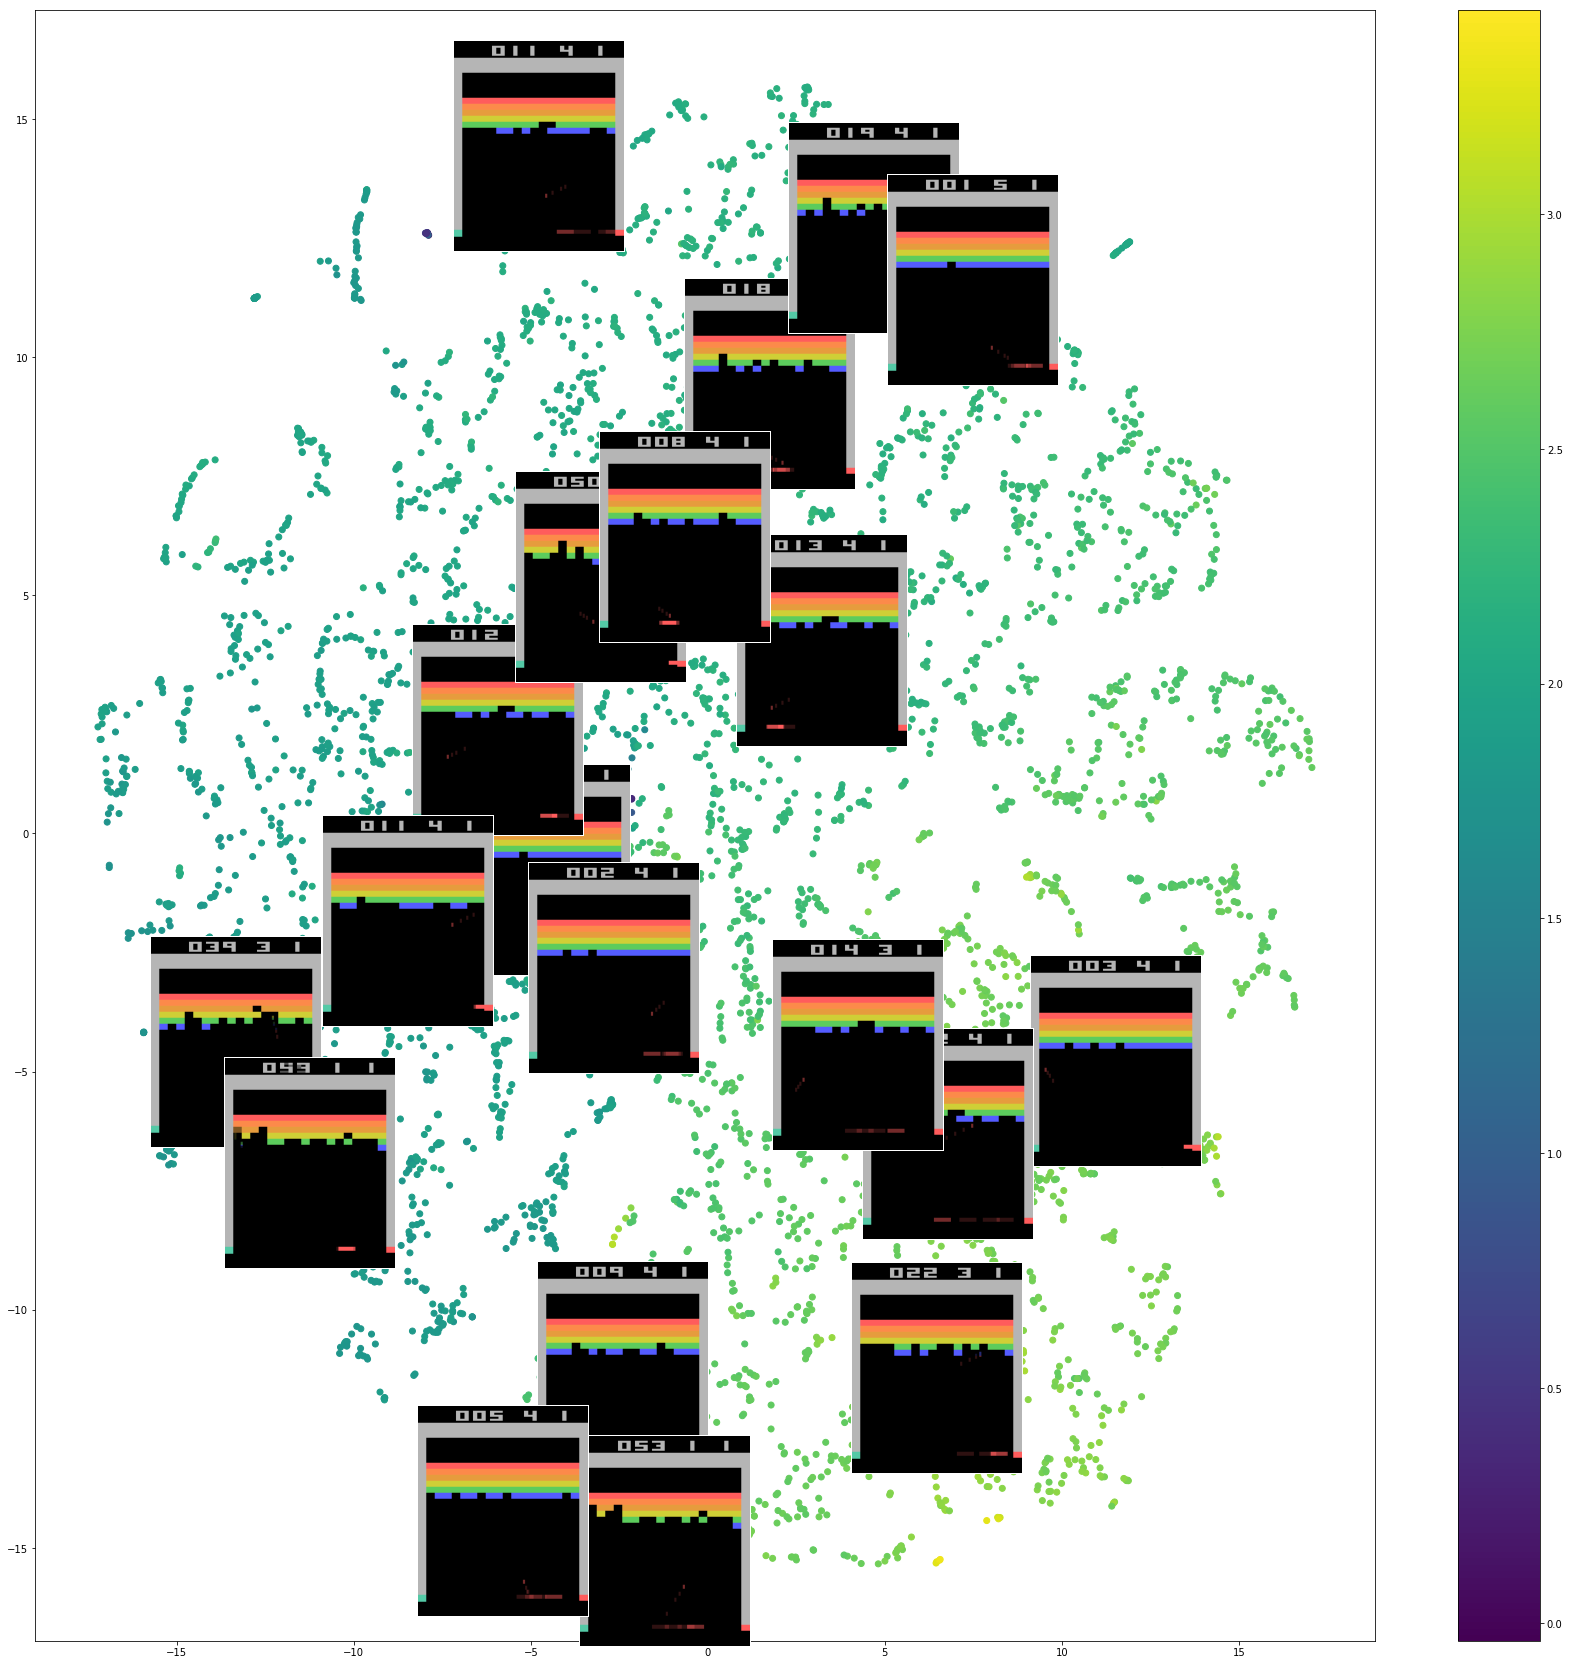

In [13]:
l =range(len(tsne_results[:,0]))
ind = random.sample(l, 20)

imx = [tsne_results[:,0][index] for index in ind]
imy = [tsne_results[:,1][index] for index in ind]
im_fig = [frames2[index] for index in ind]

fig, ax = plt.subplots(figsize=(30, 30))
imscatter(imx, imy, im_fig, zoom=0.5, ax=ax);
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


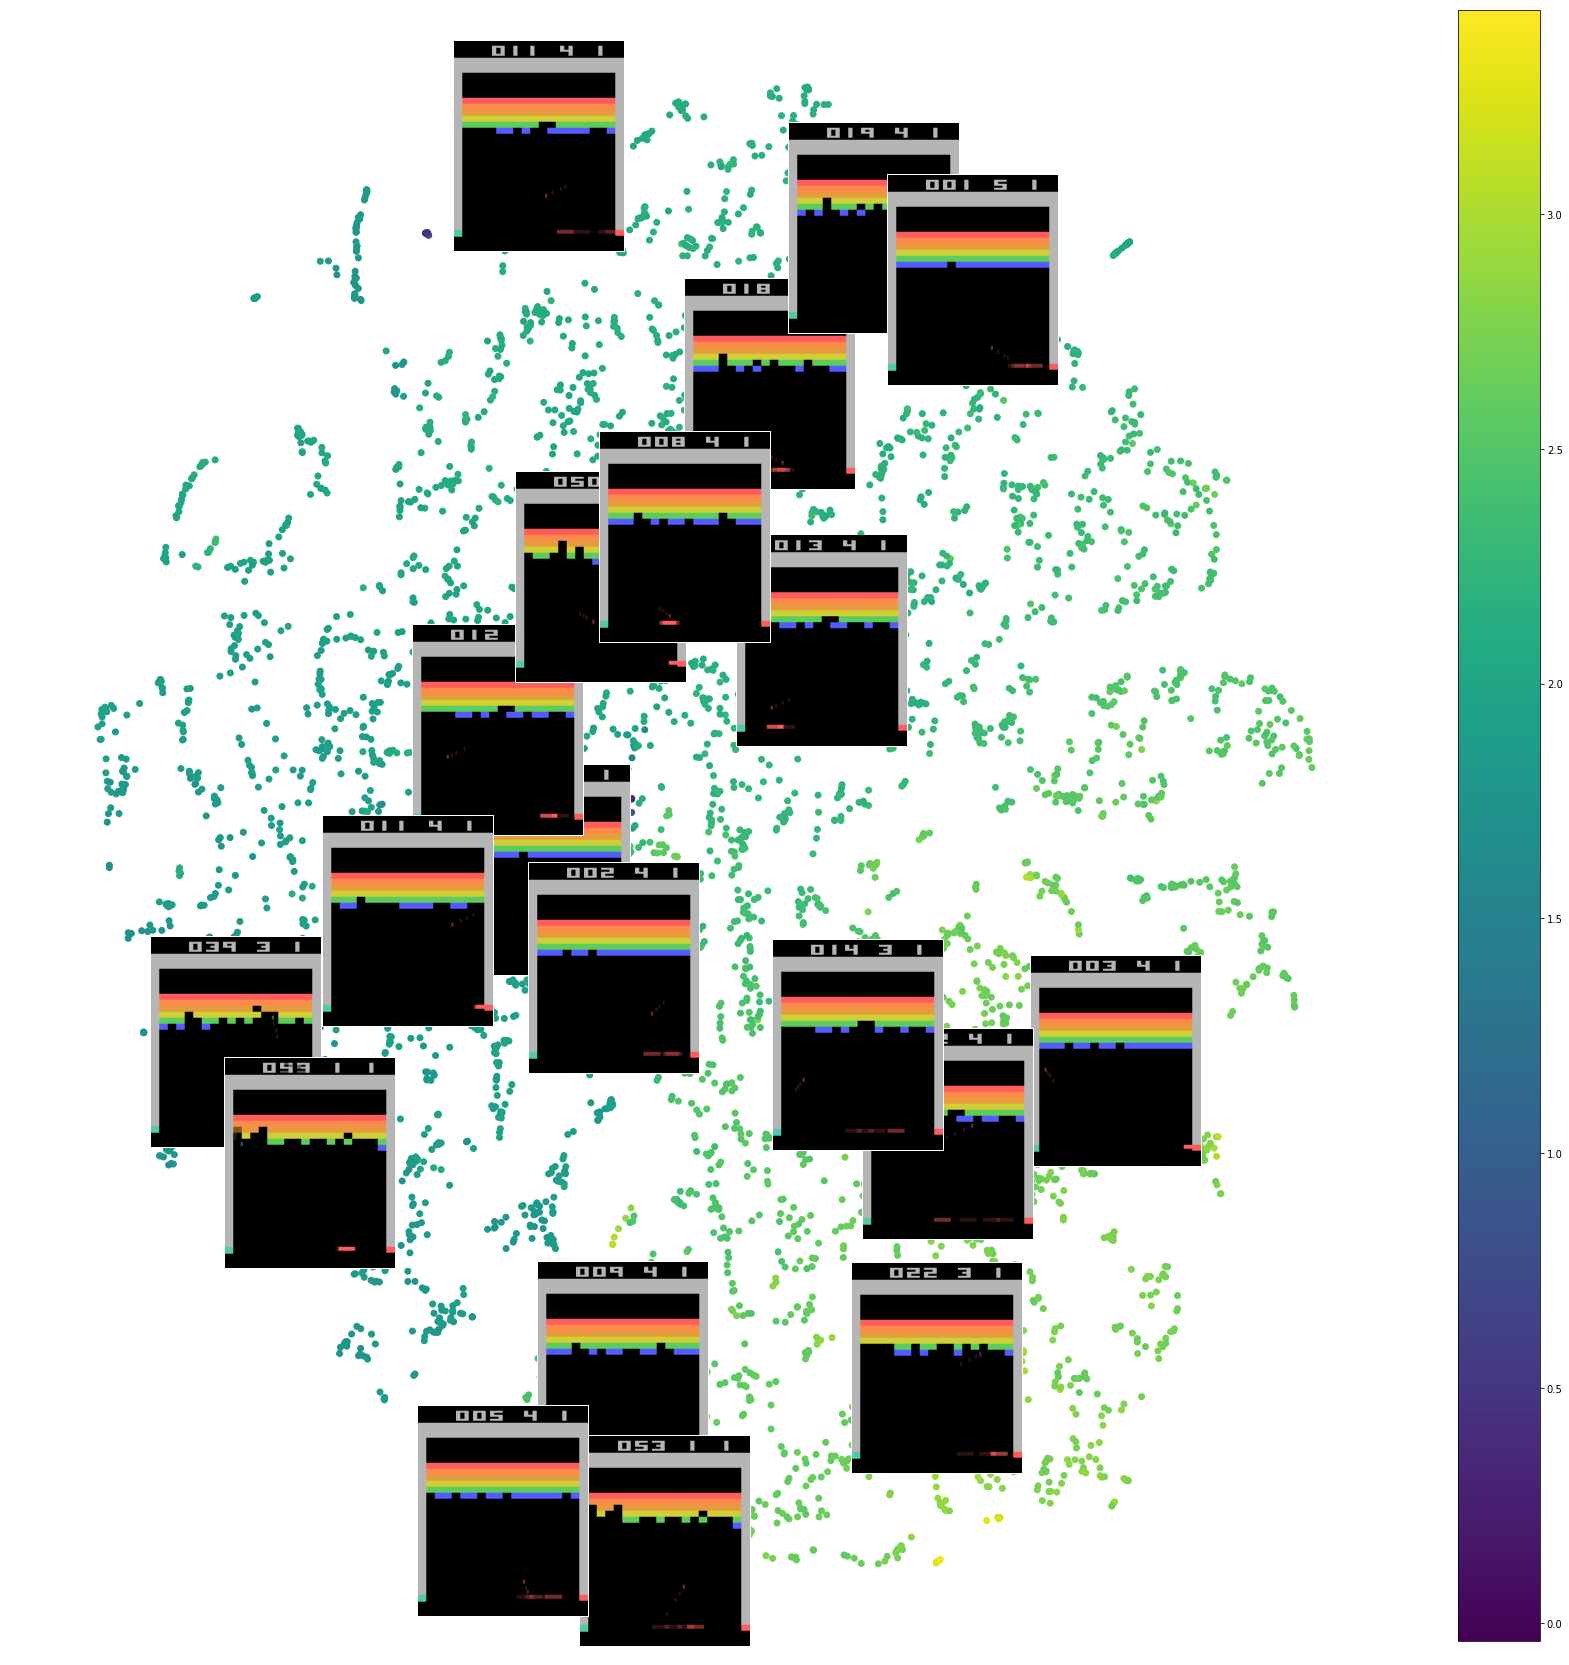

In [14]:
fig, ax = plt.subplots(figsize=(30, 30))
imscatter(imx, imy, im_fig, zoom=0.5, ax=ax);
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()
plt.axis('off')
plt.savefig("tsne_dqn_breakout.png", bbox_inches='tight')

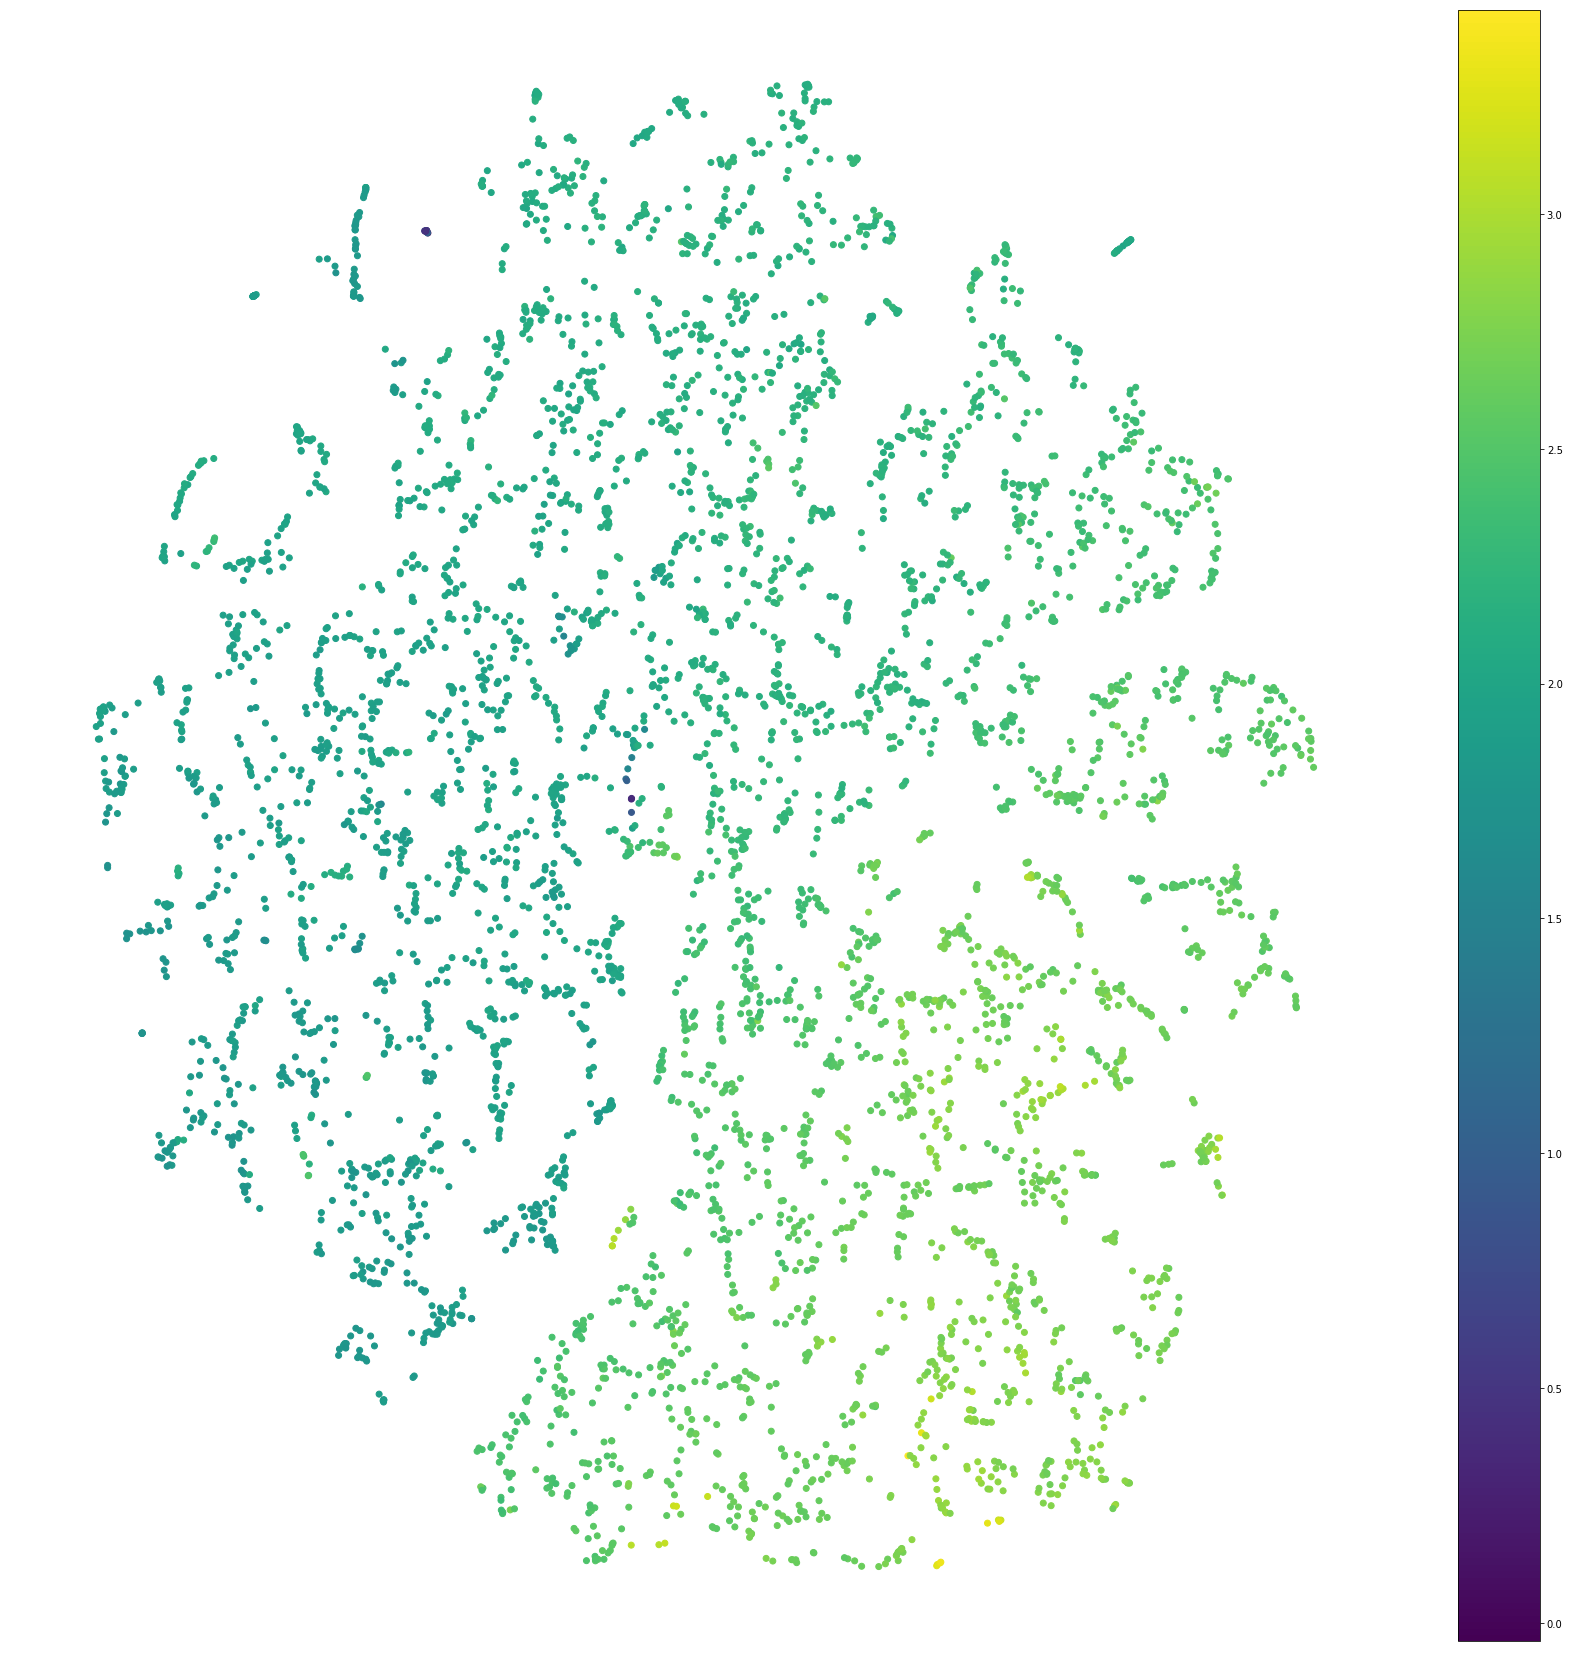

In [15]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=value_list)
plt.colorbar()
plt.axis('off')
plt.savefig("tsne_dqn_breakout_no_images.png", bbox_inches='tight')